# Project. Second part
Jose Fernández López

In [195]:
%pip install -q pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


## Data loading

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading
data = pd.read_csv('heart_disease_uci.csv')
data.head(5)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In the original paper, they use only the "Cleveland" dataset. In this part we'll use all the datasets, as the number of rows is a little limited.

If we want to use only the "Cleveland" dataset, we could do it with the following line:

In [197]:
# data = data[data['dataset'] == 'Cleveland']

Also, we could augmentate the data as shown in the paper with Random Sampling Imputation, which will help the implemented machine learning model to generalize, as it doesn't affect the variability of the randomized column, while keeping more distinct samples for the non-null values.

In [198]:
# Print columns with their data types
print(data.dtypes)

# int64: integers
# float64: decimal numbers
# object: strings

id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
num           int64
dtype: object


## Data Preprocessing
- Drop constant features
- Drop monotonic features

In [199]:
# Contant features
constant_features = [col for col in data.columns if data[col].nunique() == 1]

# Monotonic
monotonic_features = [col for col in data.columns if data[col].is_monotonic_increasing or data[col].is_monotonic_decreasing]

# Remove them
features_to_remove = set(constant_features + monotonic_features)
data = data.drop(columns=features_to_remove)

print("Removed features:")
print(features_to_remove)
print()
print("Remaining features:")
print(data.columns.tolist())


Removed features:
{'dataset', 'id'}

Remaining features:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


## Data Statistics
- Get number of rows and features
- Get and fix missing values (With imputation)

### For numerical features
- Get the mean, median, mode, standard deviation, minimum and maximum for numerical columns
- Get outliers (With IQR)
- Get the correlation matrix

### For categorical features:
- Category frequency
- Mode (Most common category)

In [200]:
# Get the number of features
print("Number of features:", len(data.columns))

# Get the number of samples
print("Number of samples:", len(data))

Number of features: 14
Number of samples: 920


In [201]:
# Find rows with missing values 
n_missing = data.isnull().sum()

print("Missing values for each feature:")
print(n_missing[n_missing > 0])
print()

# Fix missing values
for col in data.columns:

    # Check if there are missing values
    if data[col].isnull().sum() > 0:

        if data[col].dtype in ['float64', 'int64']:
            # Impute numerical columns with the median
            data[col].fillna(data[col].median(), inplace=True)
        else:
            # Impute categorical columns with the mode
            data[col].fillna(data[col].mode()[0], inplace=True)

# Check if there are still missing values
print("Remaining missing values:")
print(data.isnull().sum().sum())


Missing values for each feature:
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64

Remaining missing values:
0


/tmp/ipykernel_29992/1817494608.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
/tmp/ipykernel_29992/1817494608.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

### Numerical features

In [202]:
# Get the mean, median, mode, st dev, min, max for each numerical column
numerical_summary = data.describe().T

print("Numerical summary:")
print(numerical_summary)

Numerical summary:
          count        mean         std   min     25%    50%    75%    max
age       920.0   53.510870    9.424685  28.0   47.00   54.0   60.0   77.0
trestbps  920.0  131.995652   18.451300   0.0  120.00  130.0  140.0  200.0
chol      920.0  199.908696  109.040171   0.0  177.75  223.0  267.0  603.0
thalch    920.0  137.692391   25.145235  60.0  120.00  140.0  156.0  202.0
oldpeak   920.0    0.853261    1.058049  -2.6    0.00    0.5    1.5    6.2
ca        920.0    0.227174    0.628936   0.0    0.00    0.0    0.0    3.0
num       920.0    0.995652    1.142693   0.0    0.00    1.0    2.0    4.0


In [203]:
# Get the outliers (For numerical columns)
outliers = {}

# Outliers will be values:
# below Q1 - 1.5 * IQR
# or above Q3 + 1.5 * IQR

# IQR is the interquartile range (Q3 - Q1)

for col in data.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    outliers[col] = data[(data[col] < Q1 - 1.5 * IQR) | (data[col] > Q3 + 1.5 * IQR)]

print("Rows with outliers:")
print(outliers)

Rows with outliers:
{'age': Empty DataFrame
Columns: [age, sex, cp, trestbps, chol, fbs, restecg, thalch, exang, oldpeak, slope, ca, thal, num]
Index: [], 'trestbps':      age     sex               cp  trestbps   chol    fbs           restecg  \
14    52    Male      non-anginal     172.0  199.0   True            normal   
83    68    Male      non-anginal     180.0  274.0   True    lv hypertrophy   
126   56  Female     asymptomatic     200.0  288.0   True    lv hypertrophy   
172   59  Female     asymptomatic     174.0  249.0  False            normal   
183   59    Male   typical angina     178.0  270.0  False    lv hypertrophy   
188   54    Male  atypical angina     192.0  283.0  False    lv hypertrophy   
201   64  Female     asymptomatic     180.0  325.0  False            normal   
213   66  Female     asymptomatic     178.0  228.0   True            normal   
231   55  Female     asymptomatic     180.0  327.0  False  st-t abnormality   
338   39    Male  atypical angina     190.0

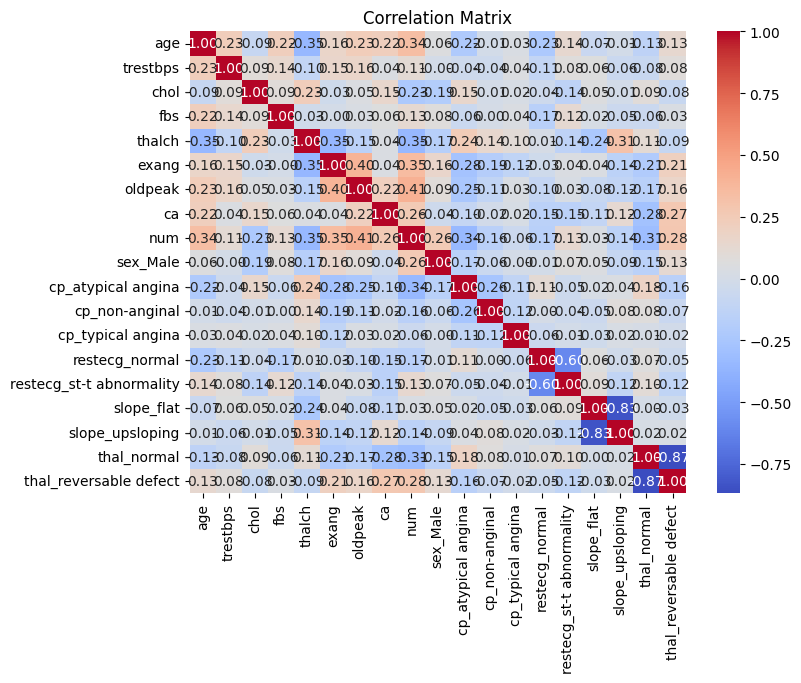

Highly correlated features:
{'thal_reversable defect', 'slope_upsloping'}


In [204]:
# Encode categorical columns
encoded_data = pd.get_dummies(data, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = encoded_data.corr()

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Find highly correlated features
correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print("Highly correlated features:")
print(correlated_features)

### Categorical features

In [205]:
# Get the frecuency of each category (For each categorical column)
categorical_columns = data.select_dtypes(include=['object']).columns

for col in categorical_columns:
    print(data[col].value_counts())
    print()
    

sex
Male      726
Female    194
Name: count, dtype: int64

cp
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: count, dtype: int64

restecg
normal              553
lv hypertrophy      188
st-t abnormality    179
Name: count, dtype: int64

slope
flat           654
upsloping      203
downsloping     63
Name: count, dtype: int64

thal
normal               682
reversable defect    192
fixed defect          46
Name: count, dtype: int64



In [206]:
# Get the mode for each categorical column
modes = data[categorical_columns].mode()

print("Modes:")
print(modes)

Modes:
    sex            cp restecg slope    thal
0  Male  asymptomatic  normal  flat  normal


## Visualization

- Histogram of features (Shows the distribution of the column values)
- Line diagram of features (Visually shows the changes on the dataset values, as the row number increases)

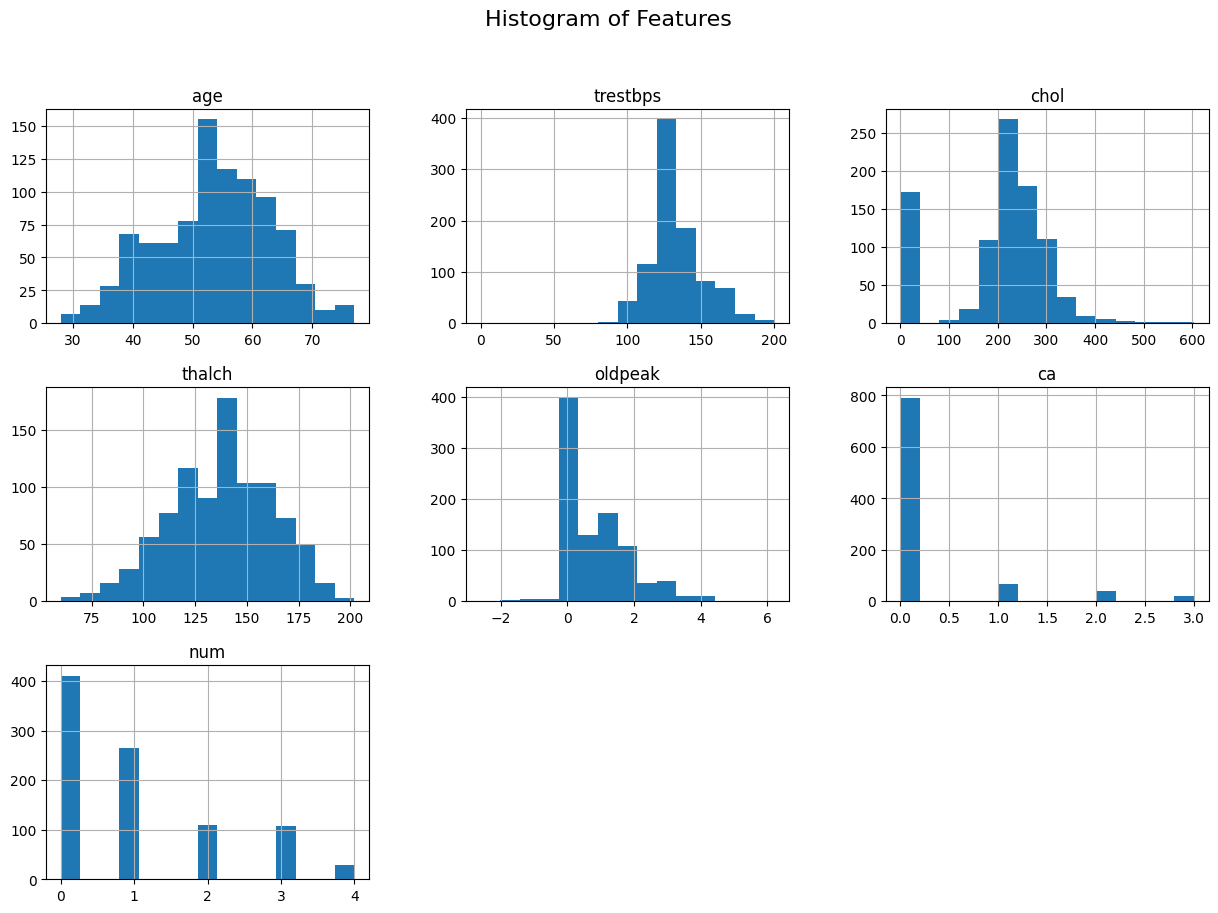

In [207]:
# Histogram of features
data.hist(bins=15, figsize=(15, 10))
plt.suptitle('Histogram of Features', fontsize=16)
plt.show()

With this visualization, we can easily see some interesting facts about the dataset.

For example, there's more data of people from ages 50 to 60 than the rest. This could result in the models predicting better for people within this range than for a 30-year-old person.

Also, the "num" category (The target category), which shows the life expendency of the patient, shows that there're more patients with expectancy 0 (Up to 60 years), than 4 (80 or more years), so the models will be more capable of giving better results for people in category 0 than the rest (As explained above).

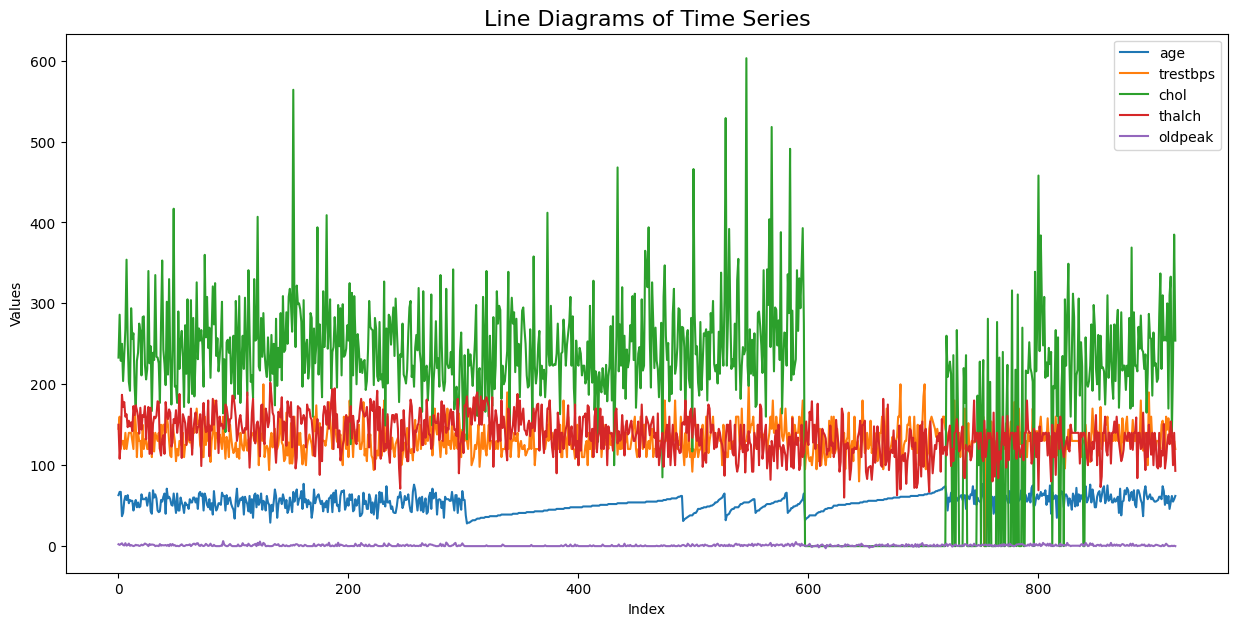

In [208]:
# Time series: Assume the rows are indexed in order of time (if applicable)
# Generate line plots for numerical features
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
data[numerical_features].plot(kind='line', figsize=(15, 7))
plt.title('Line Diagrams of Time Series', fontsize=16)
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend(loc='upper right')
plt.show()

This visualization is useful for learning how the data changes as it was inserted on the dataset. The ramps are a special case, as we created them when we performed missing value imputation.

In [209]:
age_labels = {
    0: "Up to 60 years",
    1: "60-69 years",
    2: "70-75 years",
    3: "76-79 years",
    4: "80+ years"
}

# Map the categorical labels to the 'num' column
data['num_label'] = data['num'].map(age_labels)

This are the labels for the categories of the target column, inserted into a temp column named "num_label"

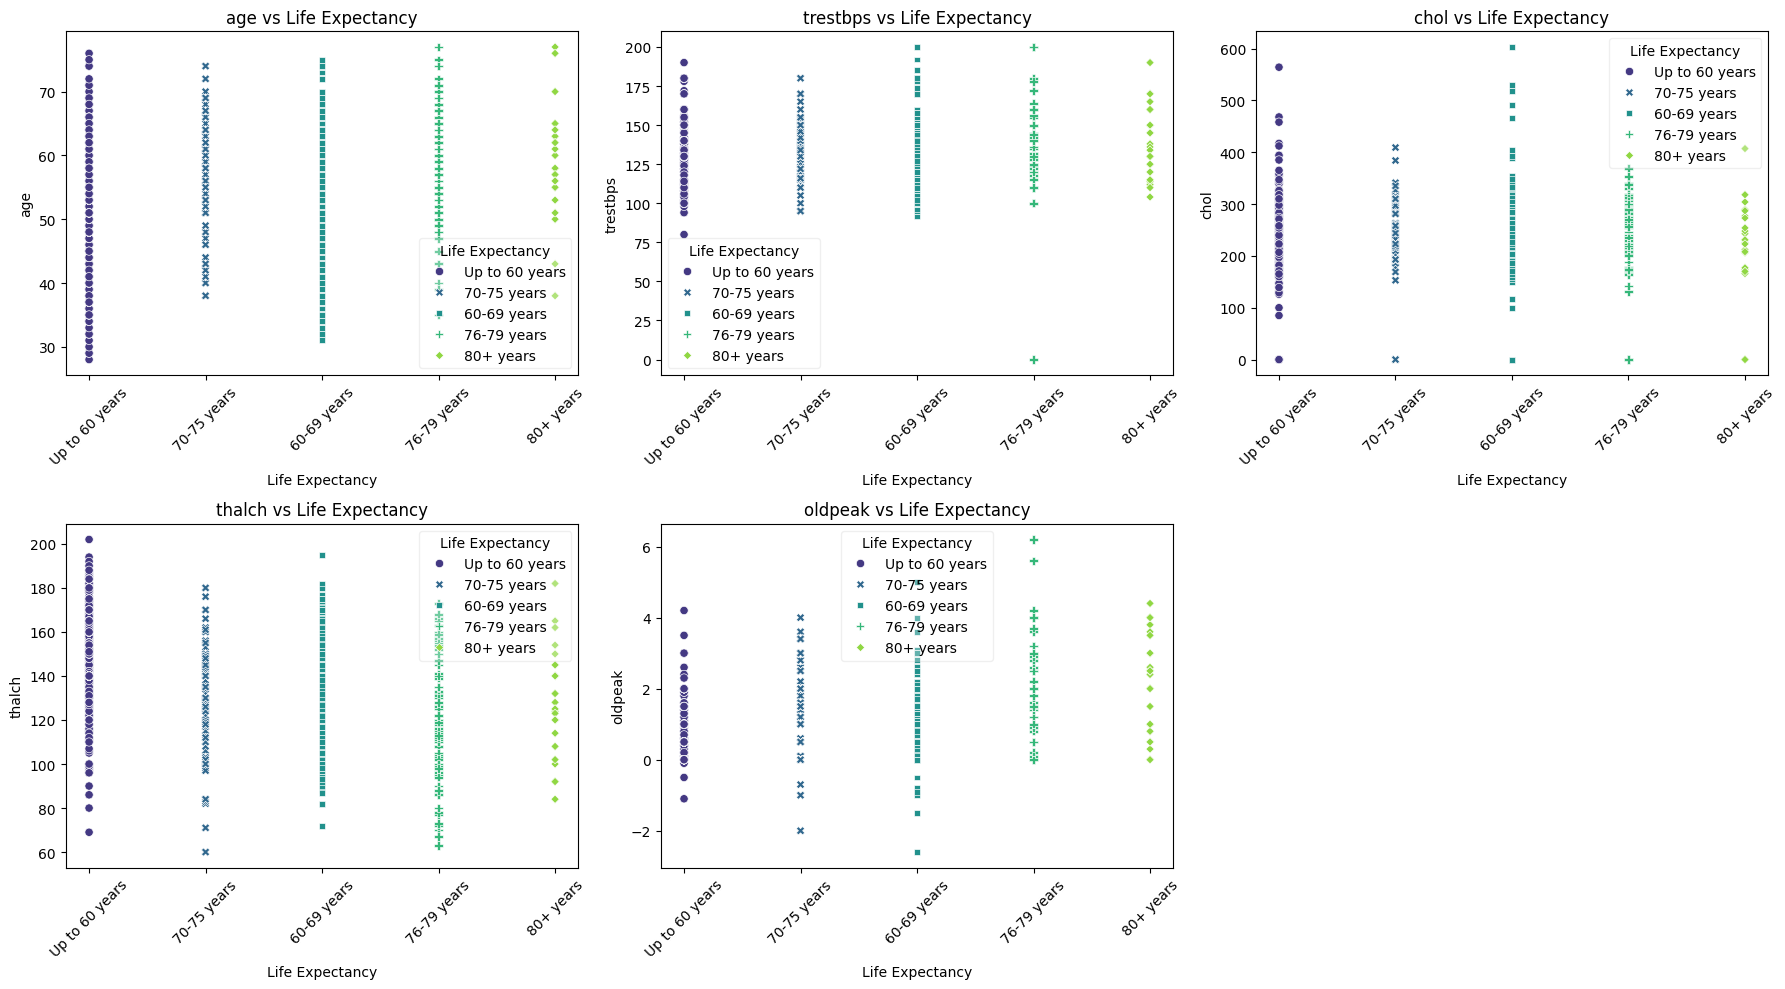

In [210]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.scatterplot(ax=axes[i], data=data, x='num_label', y=feature, hue='num_label', palette='viridis', style='num_label')
    axes[i].set_title(f'{feature} vs Life Expectancy')
    axes[i].set_xlabel('Life Expectancy')
    axes[i].set_ylabel(feature)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Life Expectancy').get_frame().set_alpha(0.3)

# Turn off the unused subplot (if there are any)
for i in range(len(numerical_features), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

This visualization is also useful, as we can see that in the categories where there're more points, is the ones who have more data. For example, on the "thalch vs Life Expectancy" there are much more rows of data with the target expectancy of up to 60 years.

Also we can see that the height gaps where there're little to no points, is the range where is very unprobable to target a person in that category based on the value. For example, in the "age vs Life Expectency", we can see that there's very little chance for a person around 30 years to have a life expectancy of more than 80 years.

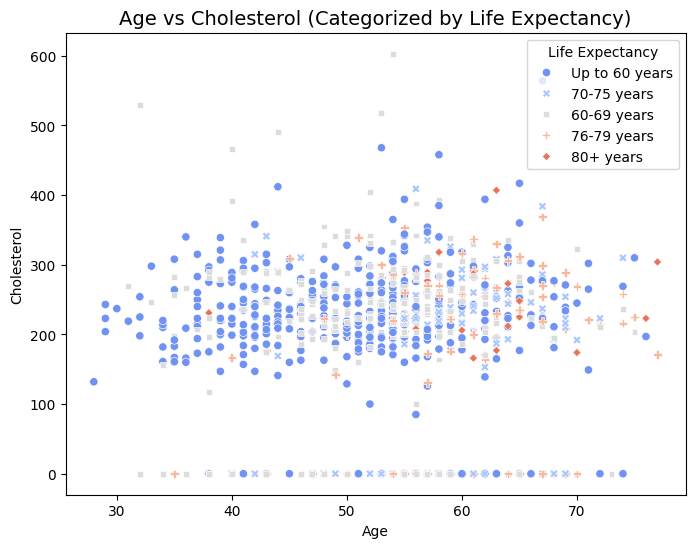

In [211]:
# Age vs Cholesterol with updated labels
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='age', y='chol', hue='num_label', palette='coolwarm', style='num_label')
plt.title('Age vs Cholesterol (Categorized by Life Expectancy)', fontsize=14)
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.legend(title='Life Expectancy')
plt.show()

Finally, in this visualization we can see some patterns of the cholesterol levels based on the age of the patient, and also identify other possible health concerns or anomalies if the patient has outlier values. For example, a patient with more than 300mg/dL of cholesterol at the age of 30 is very rare, so it could be caused by another disease or anomaly.